In [1]:
"""
all imports
"""
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import glob
import errno
import pandas as pd
from datetime import datetime
import time
import datetime
import xlrd
import pandas as pd
import numpy as np
import seaborn as sns
import math
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [2]:
"""
scans through all the maps, 
picks their names,
formats those and returns them in a list 
"""

def fetchMapDate():
    path = '/home/vijeta/Documents/Dissertation/*.png'
    files = glob.glob(path)
    maplist = []
    datelist = []
    timelist = []
    dtlist = []
    # dtlistint = []
    for name in files:
        try:
            with open(name) as f:
                filename = re.split("[map]", name)[-2][:-1]
                maplist.append(filename)
                date, time = re.split("_", filename)
    #             print(date, time)
                mm, dd, yy = [date[i:i+2] for i in range(0, len(date), 2)]
                yy = '20'+yy
                hh, mi, ss = [time[i:i+2] for i in range(0, len(time), 2)]
    #             print(mm, dd, yy)
    #             print(hh, mi, ss)
                n_date = '-'.join([yy,mm,dd])
                datelist.append(n_date)
                n_time = ':'.join([hh,mi,ss])
                timelist.append(n_time)
                datetime = ' '.join([n_date,n_time])
    #             a = int(datetime.strftime('%Y-%m-%d %H:%M:%S'))
                dtlist.append(datetime)
    #             print(type(filename))
                #filename = "map"+ filename +"png"
    #             maplist.append(filename)
    #             dtlistint.append(a)
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise
    return (dtlist)

In [3]:
"""
reads the excel file with pollution data,
converts the utcdate to string,
lists and returns them to be matched
against the dates returned from mapnamefetcher()
"""
def fetchPollutionDate():
    tdf = pd.read_excel('/home/vijeta/Documents/Dissertation/rahul_us_originaldataset.xls')
    tdf['date.utc'] = tdf['date.utc'].astype(str)
    tdfxlist = list(tdf['date.utc'])
    return (tdf, tdfxlist)

In [4]:
"""
matches pollution dates against the dates of the maps,
returns the closest map comparing its time to the pollution time for each day
"""
def fetchCorrectMap(dtlist, tdfxlist):
    newdtmaplist = []
    newtdfxlist = []
    for j in dtlist:
        datetime_object = datetime.strptime(j, '%Y-%m-%d %H:%M:%S')
        newdtmaplist.append(datetime_object)
    for j in tdfxlist:
        datetime_object = datetime.strptime(j, '%Y-%m-%d %H:%M:%S')
        newtdfxlist.append(datetime_object)
    close = []
    close_check = []
    for i in range(len(newtdfxlist)):
        csv_row = newtdfxlist[i]
        differ =[]
        for j in range(len(newdtmaplist)):
            if(newdtmaplist[j]>csv_row):
                diff = newdtmaplist[j] - csv_row
            else:
                diff = csv_row - newdtmaplist[j]
            differ.append(diff)
        minimum = min(differ)
        ix = differ.index(minimum)
        closest = newdtmaplist[ix]
        close.append("map" + closest.strftime('%m%d%y_%H%M%S') + ".png")
        close_check.append("map" + closest.strftime('%m%d%y_%H%M%S') + ".png")
        close_check.append(csv_row.strftime("%Y-%m-%d %H:%M:%S"))
    return (close)

In [5]:
"""
gets the traffic numbers based on the coordinates and pixel size
"""
def fetchTrafficColour(close, x_c, y_c, buff):
    files = []
    for c in close:
        path = '/home/vijeta/Documents/Dissertation/'+ c
        files.append(path)
    sensor_coord = np.array([x_c,y_c])
    bufferLength = buff
    polygonSides = 360
    checkfile = []
    colour_int = []
    for name in files:
        try:
            with open(name) as f:
                img = Image.open(name)
                im1=np.array(img)
                x = sensor_coord[1]
                y = sensor_coord[0]
                points_list_large = []   
                for j in range(bufferLength):
                    points_list = [ (x + np.sin(angle)*j, y + np.cos(angle)*j) 
                          for angle in np.linspace(0, 2*np.pi, polygonSides, endpoint = False) ]
                    points_list_large.append(points_list)           
                points_list_big = []
                for element in points_list_large:
                    for elem in element:
                        points_list_big.append(elem)
                points_list1 = [list(elem) for elem in points_list_big]
                points_list2=[[int(float(j)) for j in i] for i in points_list1]
                points_list_unique = [list(x) for x in set(tuple(x) for x in points_list2)]
                value_points_list = []
                for x in points_list_unique:
                    value_points_list.append(im1[x[0],x[1]])
                value_points_list_trimmed = []
                for arr in value_points_list:
                    arr = np.delete(arr, 3)
                    value_points_list_trimmed.append(arr)
                colorofpixels = np.array(value_points_list_trimmed)
                colortests = [[99,214,104], [255,151,77], [242,60,50], [129,31,31]]
                trafficdensity = np.full(colorofpixels.shape,np.nan)
                for i, colortest in enumerate(colortests):
                    pixelsthataretherightcolor = np.all(colorofpixels==np.array(colortest),axis=1)
                    trafficdensity[pixelsthataretherightcolor] = i
                trafficnumbers = np.nanmean(trafficdensity)
                filename = re.split("[map]", name)[-2]
                filename = "map"+ filename +"png"
                colour_int.append(filename)
                if str(trafficnumbers) == 'nan':
                    trafficnumbers = 0                    
                colour_int.append('{0:.3f}'.format(trafficnumbers))
#                 print(name)
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise
    return (colour_int)

In [6]:
"""
fetches weather data into a dataframe,
merges it with pollution data into a new dataframe,
returns a complete dataframe
"""
def mergeWeatherPol(tdf):
    df = pd.read_csv('tahmo_Makerere_Synopticdata_febmarch_original.csv')
    merge_df = pd.merge(df, tdf, on="date.utc")
    return (merge_df)

In [7]:
"""
prepares dataframe based on all the available data,
returns dataframe with relevant columns
"""
def prepareDataFrame(colour_int, tdfxlist, merge_df):
    tradf = pd.DataFrame(np.array(colour_int).reshape(int(len(colour_int)/2),2))
    csvdf = pd.DataFrame(np.array(tdfxlist).reshape(len(tdfxlist),1))
    tradf = tradf.rename(columns={0: 'maps', 1:'trafficnumbers'})
    csvdf = csvdf.rename(columns={0: 'date.utc'})
    joindf = pd.concat([tradf,csvdf], axis=1)
    df = pd.merge(merge_df, joindf, on="date.utc")
    cols = list(df.columns.values) #Make a list of all of the columns in the df
    cols.pop(cols.index('date.utc'))
    cols.pop(cols.index('maps'))
    df = df[cols+['maps','date.utc']]
    df[['year','month','day']] = df['date.utc'].str.split('-',expand = True)
    df[['day','time']] = df['day'].str.split(' ',expand = True)
    df[['hour','min','sec']] = df['time'].str.split(':',expand = True)
    coldrop = ['year','time', 'min', 'sec']
    df = df.drop(coldrop, axis=1)
    df['month'] = pd.to_numeric(df['month'])
    df['day'] = pd.to_numeric(df['day'])
    df['hour'] = pd.to_numeric(df['hour'])
    df = df[df.value != -999]
    df = df[df.trafficnumbers != 'nan']
    dfclean = df.drop(df.columns[[0, 1, 2, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22]], axis=1)
    return (dfclean)

In [8]:
"""
gets train and test set based only on traffic data and pollution
"""
def getTrafficTrainTest(dfclean):
#     dfnew = dfclean.drop(dfclean.columns[[8, 9]], axis =1)
    dfnew = dfclean.drop(dfclean.columns[[0, 1, 2, 3, 4, 5]], axis =1)
    dfnew = dfclean.drop(dfclean.columns[[0, 1, 2, 3, 4, 5]], axis =1)
    dfnew['xhr'] = np.sin(2*np.pi*dfnew['hour']/24)
    dfnew['yhr'] = np.cos(2*np.pi*dfnew['hour']/24)
    dfnew = dfnew.drop(dfnew.columns[[2, 3]], axis =1)
    dfnew = dfnew.drop(dfnew.columns[[2]], axis =1)
    mms = MinMaxScaler()
    dfnew[['trafficnumbers','xhr','yhr']] = mms.fit_transform(dfnew[['trafficnumbers','xhr','yhr']])
    cols = dfnew.columns.tolist()
    cols = cols[1:] + cols[:1]
    dfnew = dfnew[cols]
    dfnew = dfnew.dropna()
#     print(dfnew)
    y = dfnew['value']
    X = dfnew.drop(['value'], axis=1)
    return (X, y)

In [9]:
# fetchmap = fetchMapDate()
# fetchtdf, fetchpol = fetchPollutionDate()
# fetchcorrmap = fetchCorrectMap(fetchmap, fetchpol)

In [10]:
# fetchtrafcol = fetchTrafficColour(fetchcorrmap, 1650, 1672, 50)

In [11]:
# mergewp = mergeWeatherPol(fetchtdf)
# preparedf = prepareDataFrame(fetchtrafcol, fetchpol, mergewp)
# gettraftrain, gettraftest = getTrafficTrainTest(preparedf)

In [12]:
# plt.figure(figsize=[10,10])
# plt.scatter(gettraftrain['trafficnumbers'], gettraftrain['yhr'],1)

In [13]:
# results_traf = []
# results_xhr = []
# results_yhr = []
# allcoords = []
# allcoords.append([1650, 1672])
# ###Compute correlation or whatever
# X = gettraftrain.as_matrix()
# y = gettraftest.as_matrix()
# # print(X.shape)
# # print(y.shape)
# X2 = sm.add_constant(X[:,0])
# # print(X2.shape)
# est = sm.OLS(y, X2)
# est2 = est.fit()
# print(est2.summary())
# # results_traf.append(np.corrcoef(X[:,0],y)[0,1])
# results_traf.append(np.corrcoef(X[:,0],y)[0,1])
# print(results_traf)
# # print(results_traf)
# # results_xhr.append(np.corrcoef(X[:,1],y))
# # results_yhr.append(np.corrcoef(X[:,2],y))

In [14]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# allcoords = np.array(allcoords)
# # print(allcoords)
# # plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_traf)*100)
# # plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_xhr)*100)
# plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_yhr)*100)

In [15]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# allcoords = np.array(allcoords)
# plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_xhr)*100)

In [16]:
# pol = []
# polste = []
# traf = []
# d = 0.2
# for t in np.arange(0,1,d):
#     pols = gettraftest[(gettraftrain['trafficnumbers']>t) & (gettraftrain['trafficnumbers'] < t+d) ]
#     pol.append(np.mean(pols))
#     polste.append(np.std(pols)/np.sqrt(len(pols)))
#     traf.append(t)
# plt.scatter(traf, np.array(pol)+np.array(polste))
# plt.scatter(traf, pol)

In [17]:
# import seaborn as sns
# plt.figure(figsize=[10,10])
# df = pd.concat([gettraftrain, gettraftest], axis = 1)
# corr = df.corr()
# sns.heatmap(corr, cmap='YlGnBu', annot=True,linewidths=.3,linecolor='white',
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

In [18]:
results_traf = []
results_xhr = []
results_yhr = []
# y = np.array([10,20,30,40,20,30,13,13,10])
allcoords = []
for coordx in range(0,3000,500):
    for coordy in range(0,3000,500):
        fetchmap = fetchMapDate()
#         print(fetchmap)
        fetchtdf, fetchpol = fetchPollutionDate()
#         print(fetchtdf)
#         print("\n")
#         print(fetchpol)
#         print("\n")
        fetchcorrmap = fetchCorrectMap(fetchmap, fetchpol)
#         print(fetchcorrmap)
#         print(coordx)
#         print(coordy)
        print("The coordinates are: ", coordx, ",", coordy)
        fetchtrafcol = fetchTrafficColour(fetchcorrmap, coordx, coordy, 50)
#         print("\n")
#         print(fetchtrafcol)
#         print("\n")
        mergewp = mergeWeatherPol(fetchtdf)
#         print("mergewp \n")
        preparedf = prepareDataFrame(fetchtrafcol, fetchpol, mergewp)
#         print(preparedf)
        X, y = getTrafficTrainTest(preparedf)
#         X, y = getTrafficTrainTest(coordx,coordy)
        allcoords.append([coordx,coordy])
        ###Compute correlation or whatever
        X = X.as_matrix()
        y = y.as_matrix()
        X2 = sm.add_constant(X[:,0])
        est = sm.OLS(y, X2)
        est2 = est.fit()
        print(est2.summary())
        results_traf.append(np.corrcoef(X[:,0],y)[0,1])
        results_xhr.append(np.corrcoef(X[:,1],y)[0,1])
        results_yhr.append(np.corrcoef(X[:,2],y)[0,1])

The coordinates are:  0 , 0


/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value e

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Aug 2019   Prob (F-statistic):                nan
Time:                        03:24:34   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1002   BIC:                             9662.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6421      0.941     63.381      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value e

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Aug 2019   Prob (F-statistic):                nan
Time:                        03:33:43   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1002   BIC:                             9662.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6421      0.941     63.381      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value e

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Aug 2019   Prob (F-statistic):                nan
Time:                        03:42:42   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1002   BIC:                             9662.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6421      0.941     63.381      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.907
Date:                Wed, 21 Aug 2019   Prob (F-statistic):             0.0153
Time:                        03:52:08   Log-Likelihood:                -4824.5
No. Observations:                1003   AIC:                             9653.
Df Residuals:                    1001   BIC:                             9663.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.4231      1.064     54.894      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6623
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.416
Time:                        04:01:10   Log-Likelihood:                -4827.1
No. Observations:                1003   AIC:                             9658.
Df Residuals:                    1001   BIC:                             9668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.8201      0.966     61.909      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7717
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.380
Time:                        04:10:12   Log-Likelihood:                -4827.1
No. Observations:                1003   AIC:                             9658.
Df Residuals:                    1001   BIC:                             9668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7740      0.953     62.721      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value e

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Aug 2019   Prob (F-statistic):                nan
Time:                        04:19:14   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1002   BIC:                             9662.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6421      0.941     63.381      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8963
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.344
Time:                        04:28:16   Log-Likelihood:                -4827.0
No. Observations:                1003   AIC:                             9658.
Df Residuals:                    1001   BIC:                             9668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.0379      1.137     51.923      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value e

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Aug 2019   Prob (F-statistic):                nan
Time:                        04:37:18   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1002   BIC:                             9662.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6421      0.941     63.381      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.007214
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.932
Time:                        04:46:19   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9659.
Df Residuals:                    1001   BIC:                             9669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6942      1.124     53.129      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.08722
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.768
Time:                        04:55:38   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9659.
Df Residuals:                    1001   BIC:                             9669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.5104      1.042     57.127      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value e

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Aug 2019   Prob (F-statistic):                nan
Time:                        05:04:51   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1002   BIC:                             9662.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6421      0.941     63.381      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5116
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.475
Time:                        05:13:50   Log-Likelihood:                -4827.2
No. Observations:                1003   AIC:                             9658.
Df Residuals:                    1001   BIC:                             9668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.0042      1.069     56.143      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.448
Date:                Wed, 21 Aug 2019   Prob (F-statistic):             0.0352
Time:                        05:22:50   Log-Likelihood:                -4825.2
No. Observations:                1003   AIC:                             9654.
Df Residuals:                    1001   BIC:                             9664.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.6091      1.045     57.982      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.133
Date:                Wed, 21 Aug 2019   Prob (F-statistic):             0.0770
Time:                        05:31:51   Log-Likelihood:                -4825.9
No. Observations:                1003   AIC:                             9656.
Df Residuals:                    1001   BIC:                             9666.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.2194      1.237     47.073      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.017
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.156
Time:                        05:40:52   Log-Likelihood:                -4826.4
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1001   BIC:                             9667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.8241      1.103     53.339      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value e

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Aug 2019   Prob (F-statistic):                nan
Time:                        05:49:52   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1002   BIC:                             9662.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6421      0.941     63.381      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5878
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.443
Time:                        05:59:08   Log-Likelihood:                -4827.1
No. Observations:                1003   AIC:                             9658.
Df Residuals:                    1001   BIC:                             9668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.2516      1.232     48.904      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.755
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.186
Time:                        06:08:15   Log-Likelihood:                -4826.6
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1001   BIC:                             9667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.2115      1.034     58.219      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     10.74
Date:                Wed, 21 Aug 2019   Prob (F-statistic):            0.00108
Time:                        06:17:18   Log-Likelihood:                -4822.1
No. Observations:                1003   AIC:                             9648.
Df Residuals:                    1001   BIC:                             9658.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.0027      1.062     54.632      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.425
Date:                Wed, 21 Aug 2019   Prob (F-statistic):             0.0200
Time:                        06:26:22   Log-Likelihood:                -4824.7
No. Observations:                1003   AIC:                             9653.
Df Residuals:                    1001   BIC:                             9663.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.8811      1.344     46.051      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     41.96
Date:                Wed, 21 Aug 2019   Prob (F-statistic):           1.46e-10
Time:                        06:37:34   Log-Likelihood:                -4806.8
No. Observations:                1003   AIC:                             9618.
Df Residuals:                    1001   BIC:                             9628.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.5990      2.203     32.960      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.401
Date:                Wed, 21 Aug 2019   Prob (F-statistic):             0.0362
Time:                        06:58:31   Log-Likelihood:                -4825.2
No. Observations:                1003   AIC:                             9654.
Df Residuals:                    1001   BIC:                             9664.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.9752      1.230     47.121      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/vijeta/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value e

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 21 Aug 2019   Prob (F-statistic):                nan
Time:                        07:07:40   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9657.
Df Residuals:                    1002   BIC:                             9662.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.6421      0.941     63.381      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.562
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.110
Time:                        07:18:31   Log-Likelihood:                -4826.2
No. Observations:                1003   AIC:                             9656.
Df Residuals:                    1001   BIC:                             9666.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.7834      1.083     54.301      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7472
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.388
Time:                        07:28:48   Log-Likelihood:                -4827.1
No. Observations:                1003   AIC:                             9658.
Df Residuals:                    1001   BIC:                             9668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.0958      1.134     52.130      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.668
Date:                Wed, 21 Aug 2019   Prob (F-statistic):             0.0175
Time:                        07:39:32   Log-Likelihood:                -4824.6
No. Observations:                1003   AIC:                             9653.
Df Residuals:                    1001   BIC:                             9663.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.8520      1.068     57.002      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8754
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.350
Time:                        07:50:27   Log-Likelihood:                -4827.0
No. Observations:                1003   AIC:                             9658.
Df Residuals:                    1001   BIC:                             9668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.0002      1.016     59.061      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.04825
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.826
Time:                        08:01:46   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9659.
Df Residuals:                    1001   BIC:                             9669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7301      1.023     58.376      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.206
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.272
Time:                        08:13:01   Log-Likelihood:                -4826.8
No. Observations:                1003   AIC:                             9658.
Df Residuals:                    1001   BIC:                             9668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.9115      0.972     61.614      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.810
Date:                Wed, 21 Aug 2019   Prob (F-statistic):             0.0512
Time:                        08:23:50   Log-Likelihood:                -4825.5
No. Observations:                1003   AIC:                             9655.
Df Residuals:                    1001   BIC:                             9665.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.2502      0.961     61.662      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05311
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.818
Time:                        08:34:10   Log-Likelihood:                -4827.4
No. Observations:                1003   AIC:                             9659.
Df Residuals:                    1001   BIC:                             9669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.7895      1.138     52.530      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.929
Date:                Wed, 21 Aug 2019   Prob (F-statistic):             0.0151
Time:                        08:44:06   Log-Likelihood:                -4824.5
No. Observations:                1003   AIC:                             9653.
Df Residuals:                    1001   BIC:                             9663.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.7122      1.266     48.728      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     14.47
Date:                Wed, 21 Aug 2019   Prob (F-statistic):           0.000151
Time:                        08:56:46   Log-Likelihood:                -4820.2
No. Observations:                1003   AIC:                             9644.
Df Residuals:                    1001   BIC:                             9654.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.8978      1.107     55.917      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3225
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.570
Time:                        09:10:26   Log-Likelihood:                -4827.3
No. Observations:                1003   AIC:                             9659.
Df Residuals:                    1001   BIC:                             9668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.9723      1.106     54.202      0.0

/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/vijeta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/vijeta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.545
Date:                Wed, 21 Aug 2019   Prob (F-statistic):              0.111
Time:                        09:23:16   Log-Likelihood:                -4826.2
No. Observations:                1003   AIC:                             9656.
Df Residuals:                    1001   BIC:                             9666.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.3538      1.239     47.080      0.0

In [19]:
# import pandas as pd
# import numpy as np
# from sklearn import linear_model
# from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm
# from scipy import stats

# X = np.random.rand(100,2)
# X -= np.mean(X,0)
# print(X.shape)
# y = np.random.randn(100)+X[:,0]
# print(y.shape)
# X2 = sm.add_constant(X)
# print(X2.shape)
# est = sm.OLS(y, X2)
# est2 = est.fit()
# print(est2.summary())

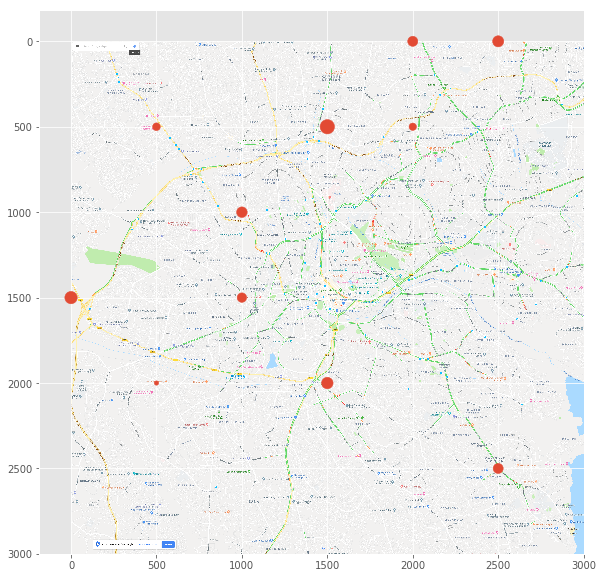

In [37]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_traf)*2000)

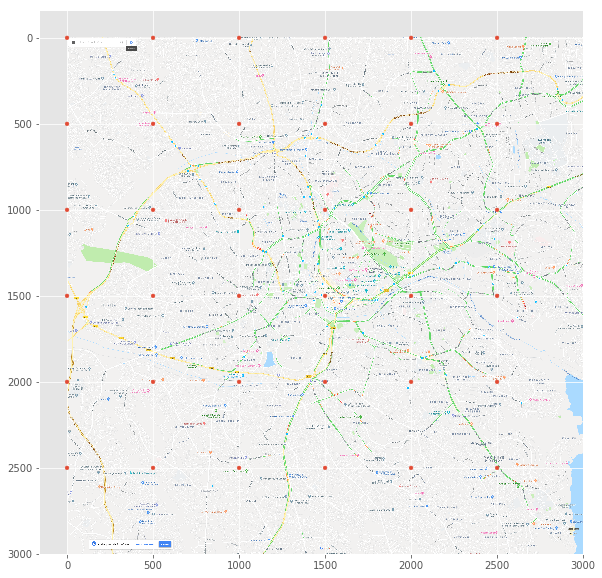

In [35]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_xhr)*100)

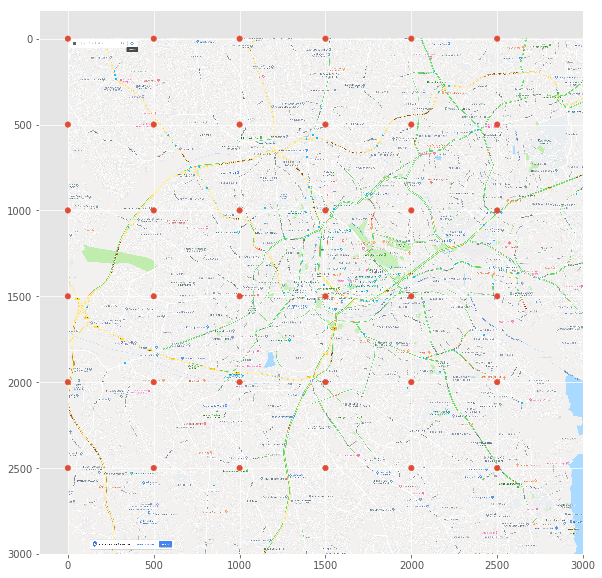

In [38]:
plt.figure(figsize=[10,10])
allcoords = np.array(allcoords)
im = plt.imread('imagemap.png')
implot = plt.imshow(im)
plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results_yhr)*100)

In [21]:
# import statsmodels.api as sm
# Y = [1,3,4,5,2,3,4]
# # print(Y.shape)
# X = range(1,8)
# # print(X.shape)
# X = sm.add_constant(X)
# print(X.shape)
# model = sm.OLS(Y,X)
# results = model.fit()
# results.params

In [22]:
# import pandas as pd
# import numpy as np
# from sklearn import linear_model
# from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm
# from scipy import stats

# import numpy as np
# def getmytraffic(x,y):
#     return np.random.rand(9)

# results = []
# y = np.array([10,20,30,40,20,30,13,13,10])
# allcoords = []
# for coordx in range(0,3000,200):
#     for coordy in range(0,3000,200):
#         X = getmytraffic(coordx,coordy)
#         allcoords.append([coordx,coordy])
#         ###Compute correlation or whatever
#         print(X.shape)
#         print(y.shape)
#         X2 = sm.add_constant(X)
#         est = sm.OLS(y, X2)
#         est2 = est.fit()
#         print(est2.summary())
#         results.append(np.corrcoef(X,y)[0,1])

In [23]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# allcoords = np.array(allcoords)
# plt.scatter(allcoords[:,0],allcoords[:,1],np.array(results)*100)

In [41]:
preparedf.dtypes

humidity (%)            int64
precipitation (mm)    float64
pressure (kPa)        float64
radiation (W/m2)      float64
temperature (oC)      float64
windspeed (m/s)       float64
value                   int64
trafficnumbers         object
month                   int64
day                     int64
hour                    int64
dtype: object